In [ ]:
# In this notebook, we will
# 1. Smooth the trajectory, both positions, and quaternions
# 2. Estimate and scale the speed to 0-1 normalize
!pip install pandas
!pip install matplotlib
!pip install tensorflow

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [2]:
# Path to the file
file_path = './output/frame_trajectory.txt'

# Read the space-separated txt file into a DataFrame
df = pd.read_table(file_path, delim_whitespace=True, header=None, 
                   names=['timestamp', 'x', 'y', 'z', 'qx', 'qy', 'qz', 'qw'])

# Print the first 10 values of x, y, z columns
print(df[['timestamp','x', 'y', 'z']].head(2))


   timestamp         x         y         z
0   0.834168 -0.000000 -0.000000 -0.000000
1   0.867534  0.003383 -0.002231  0.017913


/tmp/ipykernel_1642/3656705580.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_table(file_path, delim_whitespace=True, header=None,


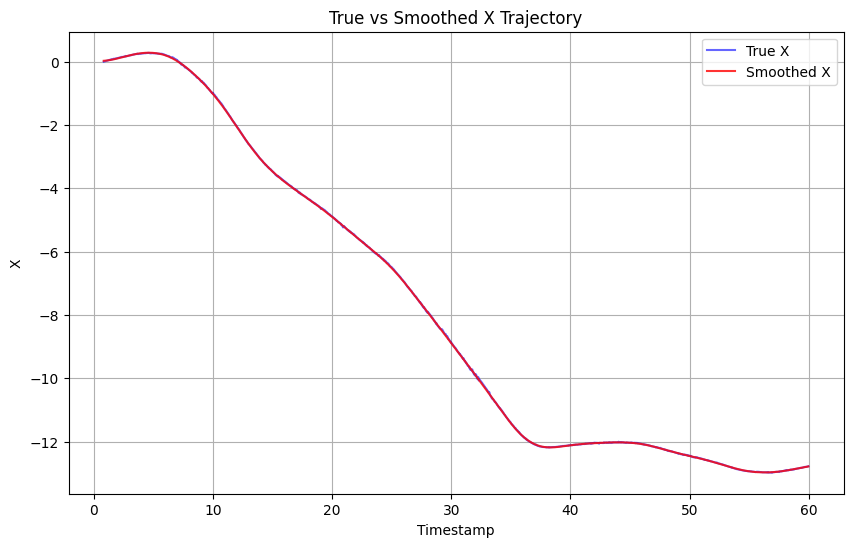

In [3]:
x_values = df['x'].values  # Replace with your actual 'x' values from DataFrame

# Apply the Savitzky-Golay filter to smooth the data
# window_length is the size of the filter window (it should be an odd number)
# polyorder is the order of the polynomial used to fit the filter
# MUST: config window_length and polyorder manually, ask gpt how that work
smoothed_x = savgol_filter(x_values, window_length=256, polyorder=4)
df['smoothed_x']= smoothed_x
# Plot the original (true) data vs. the smoothed data
plt.figure(figsize=(10, 6))
plt.plot(df['timestamp'], x_values, label='True X', color='b', alpha=0.6)  # Original data
plt.plot(df['timestamp'], smoothed_x, label='Smoothed X', color='r', alpha=0.8)  # Smoothed data
plt.xlabel('Timestamp')
plt.ylabel('X')
plt.title('True vs Smoothed X Trajectory')
plt.legend()
plt.grid(True)
plt.show()


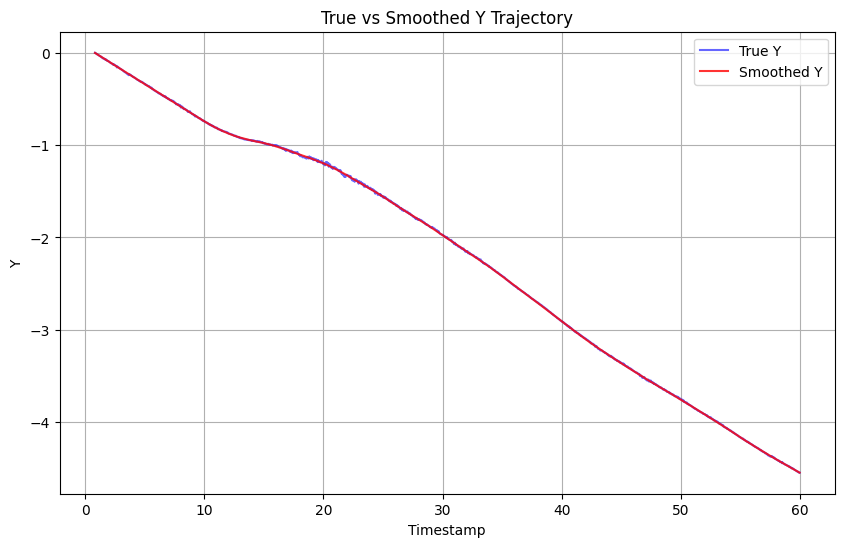

In [4]:
y_values = df['y'].values
smoothed_y = savgol_filter(y_values, window_length=256+8, polyorder=4)
df['smoothed_y']=smoothed_y
# Plot the original (true) data vs. the smoothed data
plt.figure(figsize=(10, 6))
plt.plot(df['timestamp'], y_values, label='True Y', color='b', alpha=0.6)  # Original data
plt.plot(df['timestamp'], smoothed_y, label='Smoothed Y', color='r', alpha=0.8)  # Smoothed data
plt.xlabel('Timestamp')
plt.ylabel('Y')
plt.title('True vs Smoothed Y Trajectory')
plt.legend()
plt.grid(True)
plt.show()


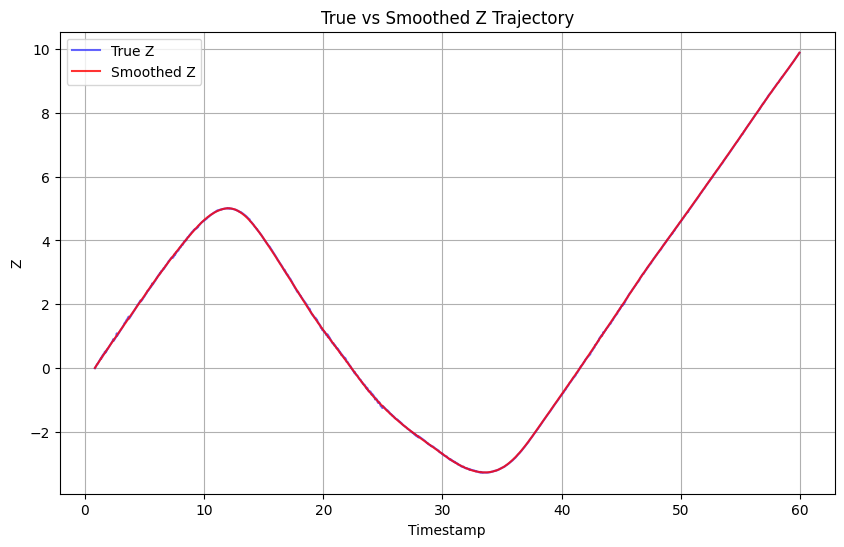

In [5]:
z_values = df['z'].values
smoothed_z = savgol_filter(z_values, window_length=256, polyorder=6)
df['smoothed_z']=smoothed_z
# Plot the original (true) data vs. the smoothed data
plt.figure(figsize=(10, 6))
plt.plot(df['timestamp'], z_values, label='True Z', color='b', alpha=0.6)  # Original data
plt.plot(df['timestamp'], smoothed_z, label='Smoothed Z', color='r', alpha=0.8)  # Smoothed data
plt.xlabel('Timestamp')
plt.ylabel('Z')
plt.title('True vs Smoothed Z Trajectory')
plt.legend()
plt.grid(True)
plt.show()
  

In [6]:
# Begin smoothing quaternions
def smooth_column(threshold, window_lengths, polyorders, df_col_name):
    """
    Smooths a column in the global DataFrame using Savitzky-Golay filter over chunks where 
    the difference in consecutive values is greater than the threshold.

    Parameters:
    - threshold (float): The threshold for detecting significant differences between consecutive values.
    - window_lengths (list of int): List of window lengths for Savitzky-Golay filter for each chunk.
    - polyorders (list of int): List of polynomial orders for Savitzky-Golay filter for each chunk.
    - df_col_name (str): The column name in the global DataFrame to smooth.

    Returns:
    - None (The global DataFrame `df` will be modified in place).
    """
    
    indices_list = [0]
    
    # Iterate through the DataFrame to find chunks based on threshold
    for i in range(1, len(df)):
        if abs(df[df_col_name][i] - df[df_col_name][i-1]) > threshold:
            if indices_list[-1] != i-1:
                indices_list.append(i)
                
    # Add the final index (end of the DataFrame)
    if indices_list[-1] != len(df)-1:
        indices_list.append(len(df))
    
    n_chunk = len(indices_list) - 1
    print("Number of chunks: ",n_chunk)
    
    # Create a new column for the smoothed data
    smoothed_col_name = f'smoothed_{df_col_name}'
    df[smoothed_col_name] = df[df_col_name]
    
    # Apply Savitzky-Golay filter to each chunk
    for i in range(n_chunk):
        start_idx, end_idx = indices_list[i], indices_list[i + 1]
        chunk_size = end_idx - start_idx

        # Ensure window length is valid
        window_length = min(window_lengths[i], chunk_size - (1 if chunk_size % 2 == 0 else 0))
        if window_length < 3:
            window_length = 3  # Ensure a minimal valid smoothing window

        df.loc[start_idx:end_idx - 1, smoothed_col_name] = savgol_filter(
            df.loc[start_idx:end_idx - 1, df_col_name], 
            window_length=window_length, 
            polyorder=polyorders[i]
        )
    
    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(df['timestamp'], df[df_col_name], label=f'Original {df_col_name}', color='r')
    plt.plot(df['timestamp'], df[f'smoothed_{df_col_name}'], label=f'Smoothed {df_col_name}', color='b')
    plt.xlabel('Timestamp')
    plt.ylabel(df_col_name)
    plt.title(f'Comparison of Original and Smoothed {df_col_name}')
    plt.grid(True)
    plt.legend()
    plt.show()

Number of chunks:  3


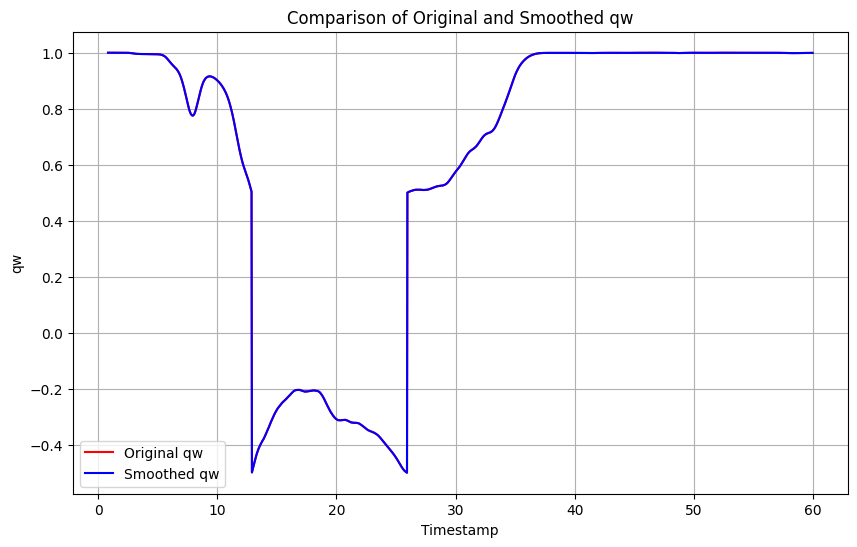

In [7]:
# README: How to tune the hyper param
# 1.See graph, edit threshold till number of chunks is true to graph
# 2.Set window_lenghts and polyorders len as number of chunks, fine-tune these hyperparam depend on each chunk
threshold = 0.5
window_lengths = [5, 5, 5]
polyorders = [2, 2, 2]
df_col_name = 'qw'

# Call the function (assuming df is already defined globally)
smooth_column(threshold, window_lengths, polyorders, df_col_name)

Number of chunks:  3


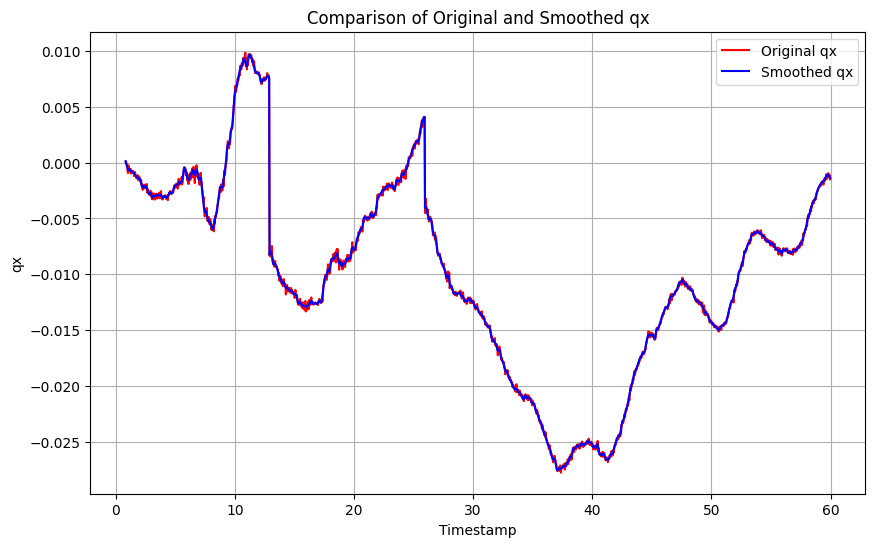

In [8]:
threshold = 0.005
window_lengths = [10,10,10]
polyorders = [2,2,2]
df_col_name = 'qx'

# Call the function (assuming df is already defined globally)
smooth_column(threshold, window_lengths, polyorders, df_col_name)

Number of chunks:  3


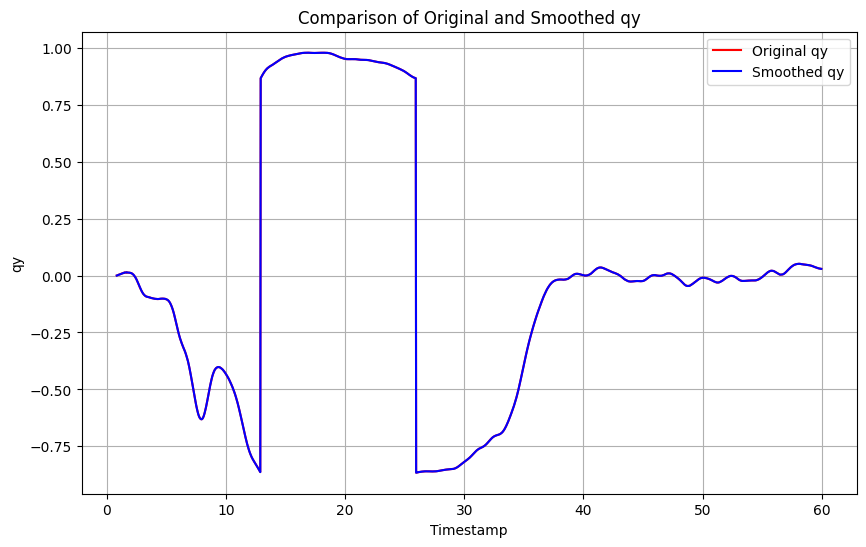

In [9]:
threshold = 0.5
window_lengths = [5,5,5]
polyorders = [2,2,2]
df_col_name = 'qy'

# Call the function (assuming df is already defined globally)
smooth_column(threshold, window_lengths, polyorders, df_col_name)


Number of chunks:  3


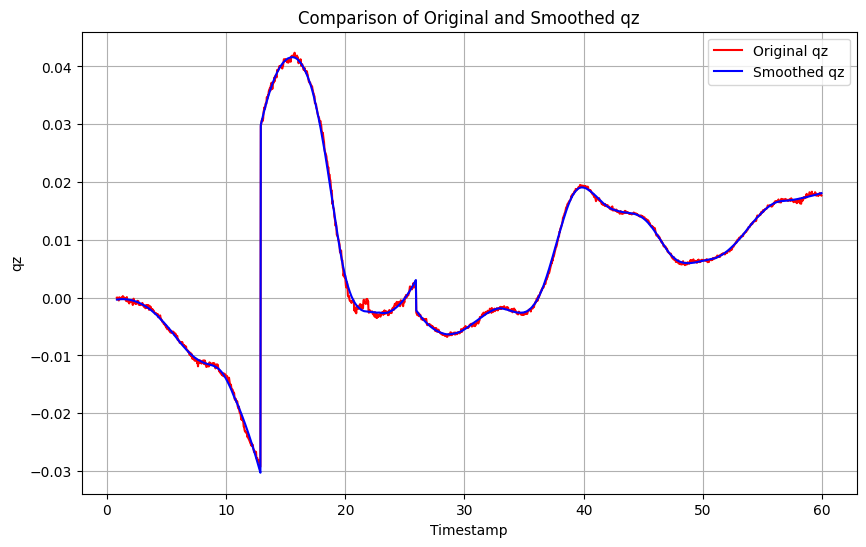

In [10]:
threshold = 0.0025
window_lengths = [128,128,128]
polyorders = [2,2,2]
df_col_name = 'qz'
smooth_column(threshold, window_lengths, polyorders, df_col_name)

In [11]:
# Normalize quaternions
columns_to_normalize = ['smoothed_qw', 'smoothed_qx', 'smoothed_qy', 'smoothed_qz']

# Function to normalize each row (quaternion)
def normalize_quaternion(row):
    norm = np.sqrt(row['smoothed_qw']**2 + row['smoothed_qx']**2 + row['smoothed_qy']**2 + row['smoothed_qz']**2)
    row['smoothed_qw'] /= norm
    row['smoothed_qx'] /= norm
    row['smoothed_qy'] /= norm
    row['smoothed_qz'] /= norm
    return row

# Apply the normalization to each row
df = df.apply(normalize_quaternion, axis=1)

In [12]:
column_names = df.columns
num_columns = len(column_names)

print(f"The number of columns in the DataFrame is: {num_columns}")
print(f"The names of the columns are: {list(column_names)}")

The number of columns in the DataFrame is: 15
The names of the columns are: ['timestamp', 'x', 'y', 'z', 'qx', 'qy', 'qz', 'qw', 'smoothed_x', 'smoothed_y', 'smoothed_z', 'smoothed_qw', 'smoothed_qx', 'smoothed_qy', 'smoothed_qz']


In [13]:
df['dx'] = df['smoothed_x'].diff()  # Change in x
df['dy'] = df['smoothed_y'].diff()  # Change in y
df['dz'] = df['smoothed_z'].diff()  # Change in z

# Calculate the time difference (timestamp is already in seconds)
df['dt'] = df['timestamp'].diff()  # Time difference in seconds

# Calculate the instantaneous velocity (magnitude of velocity vector)
df['instantaneous_velocity'] = np.sqrt(df['dx']**2 + df['dy']**2 + df['dz']**2) / df['dt']
df.loc[0:2, 'instantaneous_velocity'] = df.loc[2, 'instantaneous_velocity']

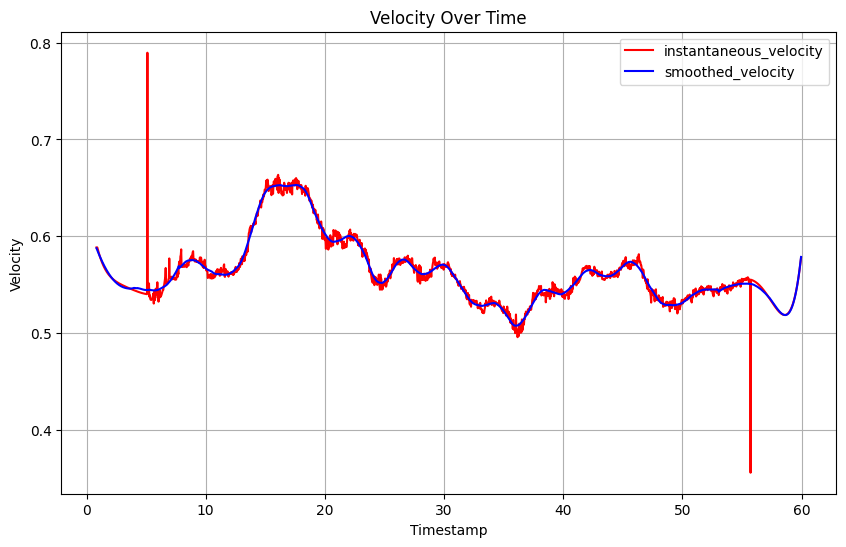

In [14]:
df['smoothed_velocity'] = savgol_filter(df['instantaneous_velocity'], 128+32, 4)

plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(df['timestamp'], df['instantaneous_velocity'], label='instantaneous_velocity', color='red')
plt.plot(df['timestamp'], df['smoothed_velocity'], label='smoothed_velocity', color='blue')
plt.xlabel('Timestamp')  # Label for the x-axis
plt.ylabel('Velocity')  # Label for the y-axis
plt.title('Velocity Over Time')  # Title of the plot
plt.legend()  # Show legend
plt.grid(True)  # Add a grid for better readability
plt.show()  # Display the plot

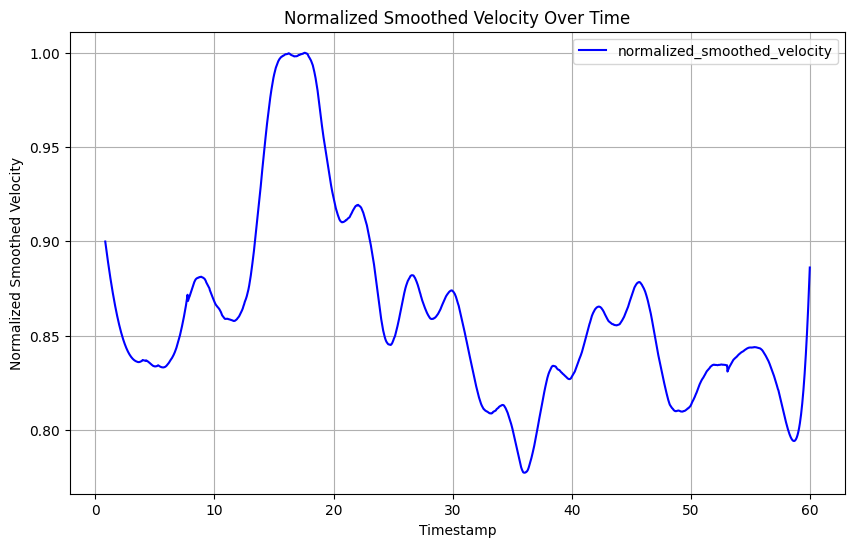

In [15]:
df['normalized_smoothed_velocity'] = df['smoothed_velocity'] / df['smoothed_velocity'].max()

plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(df['timestamp'], df['normalized_smoothed_velocity'], label='normalized_smoothed_velocity', color='blue')
plt.xlabel('Timestamp')  # Label for the x-axis
plt.ylabel('Normalized Smoothed Velocity')  # Label for the y-axis
plt.title('Normalized Smoothed Velocity Over Time')  # Title of the plot
plt.legend()  # Show legend
plt.grid(True)  # Add a grid for better readability
plt.show()  # Display the plot

In [16]:
#Save the processed data to new file
smoothed_df = pd.DataFrame({
    'timestamp': df['timestamp'],
    'x': df['smoothed_x'],
    'y': df['smoothed_y'],
    'z': df['smoothed_z'],
    'qx': df['smoothed_qx'],
    'qy': df['smoothed_qy'],
    'qz': df['smoothed_qz'],
    'qw': df['smoothed_qw'],
    'normalized_smoothed_velocity': df['normalized_smoothed_velocity']
})

# Add motion_state column: 1 if velocity > 0.05 (moving), 0 otherwise (stationary)
smoothed_df['motion_state'] = (smoothed_df['normalized_smoothed_velocity'] > 0.05).astype(int)

# Export to smoothed_trajectory.txt
output_path = './output/post_processed_trajectory.txt'
smoothed_df.to_csv(output_path, sep=' ', index=False, header=False)

In [ ]:
# Done, bring to unity